## IMPORTS & SETUP

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [ ]:
# Download MovieLens 100K dataset
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

# Load ratings data
ratings = pd.read_csv("ml-100k/u.data", sep="\t", encoding="latin-1", header=None, names=["user_id", "item_id", "rating", "timestamp"])
ratings = ratings.drop("timestamp", axis=1)  # Drop unnecessary column

# Load movie titles
titles = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None, usecols=[0, 1], names=["item_id", "title"])

# Get number of users and movies
num_users = ratings["user_id"].max()
num_movies = ratings["item_id"].max()
print(f"Number of users: {num_users}, Number of movies: {num_movies}")


File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         
Number of users: 943, Number of movies: 1682


## EXPLORATORY DATA ANALYSIS (EDA)

            user_id        item_id         rating
count  100000.00000  100000.000000  100000.000000
mean      462.48475     425.530130       3.529860
std       266.61442     330.798356       1.125674
min         1.00000       1.000000       1.000000
25%       254.00000     175.000000       3.000000
50%       447.00000     322.000000       4.000000
75%       682.00000     631.000000       4.000000
max       943.00000    1682.000000       5.000000


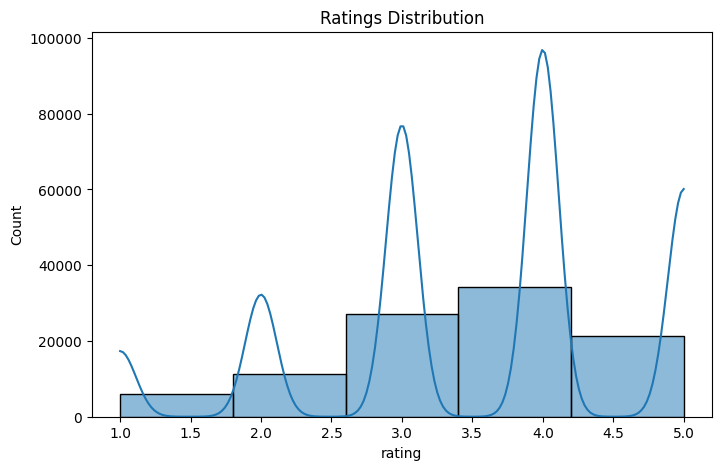

In [ ]:
print(ratings.describe())
plt.figure(figsize=(8, 5))
sns.histplot(ratings["rating"], bins=5, kde=True)
plt.title("Ratings Distribution")
plt.show()

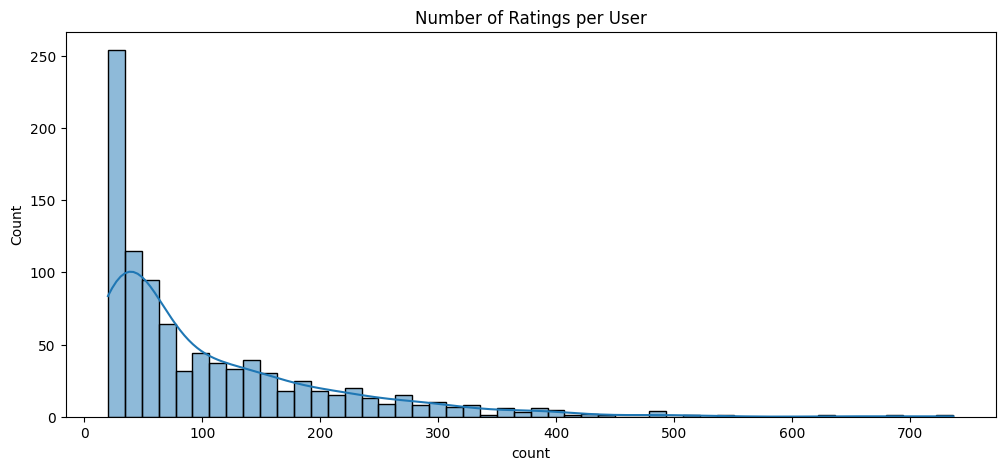

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(ratings["user_id"].value_counts(), bins=50, kde=True)
plt.title("Number of Ratings per User")
plt.show()

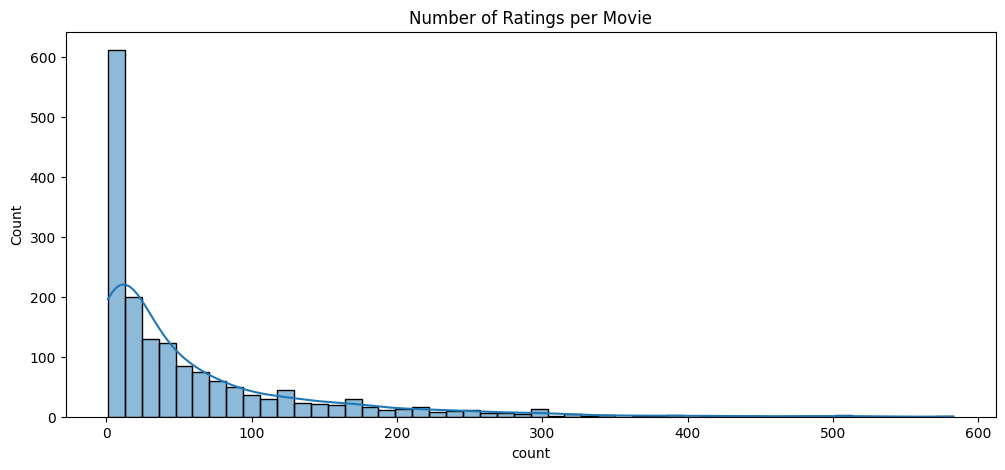

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(ratings["item_id"].value_counts(), bins=50, kde=True)
plt.title("Number of Ratings per Movie")
plt.show()

## DATA PREPROCESSING

In [ ]:
def convert_to_matrix(data):
    """Convert ratings DataFrame into a user-item matrix."""
    matrix = np.zeros((num_users, num_movies))
    for row in data.itertuples():
        matrix[row.user_id - 1, row.item_id - 1] = row.rating
    return matrix

# Split dataset into train & test sets (80-20)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Convert to matrix format
train_matrix = convert_to_matrix(train_data)
test_matrix = convert_to_matrix(test_data)

# Normalize ratings (scale to [0,1])
train_matrix = train_matrix / 5.0
test_matrix = test_matrix / 5.0

# Convert to PyTorch tensors
train_tensor = torch.FloatTensor(train_matrix)
test_tensor = torch.FloatTensor(test_matrix)

print(f"Train Tensor Shape: {train_tensor.shape}")
print(f"Test Tensor Shape: {test_tensor.shape}")


Train Tensor Shape: torch.Size([943, 1682])
Test Tensor Shape: torch.Size([943, 1682])


## AUTOENCODER MODEL

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, num_movies):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_movies, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, num_movies),
            nn.Sigmoid()  # Outputs in range [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
model = Autoencoder(num_movies)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1682, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1682, bias=True)
    (5): Sigmoid()
  )
)

## TRAINING SETUP

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = data.DataLoader(train_tensor, batch_size=64, shuffle=True)


## MODEL TRAINING

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training Complete!")

Epoch [1/50], Loss: 0.1319
Epoch [2/50], Loss: 0.0277
Epoch [3/50], Loss: 0.0277
Epoch [4/50], Loss: 0.0277
Epoch [5/50], Loss: 0.0276
Epoch [6/50], Loss: 0.0279
Epoch [7/50], Loss: 0.0280
Epoch [8/50], Loss: 0.0280
Epoch [9/50], Loss: 0.0279
Epoch [10/50], Loss: 0.0280
Epoch [11/50], Loss: 0.0280
Epoch [12/50], Loss: 0.0281
Epoch [13/50], Loss: 0.0279
Epoch [14/50], Loss: 0.0280
Epoch [15/50], Loss: 0.0279
Epoch [16/50], Loss: 0.0281
Epoch [17/50], Loss: 0.0279
Epoch [18/50], Loss: 0.0280
Epoch [19/50], Loss: 0.0280
Epoch [20/50], Loss: 0.0279
Epoch [21/50], Loss: 0.0280
Epoch [22/50], Loss: 0.0280
Epoch [23/50], Loss: 0.0280
Epoch [24/50], Loss: 0.0280
Epoch [25/50], Loss: 0.0280
Epoch [26/50], Loss: 0.0281
Epoch [27/50], Loss: 0.0280
Epoch [28/50], Loss: 0.0279
Epoch [29/50], Loss: 0.0280
Epoch [30/50], Loss: 0.0280
Epoch [31/50], Loss: 0.0280
Epoch [32/50], Loss: 0.0280
Epoch [33/50], Loss: 0.0280
Epoch [34/50], Loss: 0.0280
Epoch [35/50], Loss: 0.0281
Epoch [36/50], Loss: 0.0280
E

## MODEL EVALUATION

In [ ]:
model.eval()
test_tensor = test_tensor.to(device)

with torch.no_grad():
    predicted = model(test_tensor)  # Generate reconstructed ratings

# Compute evaluation metrics
mse = torch.nn.functional.mse_loss(predicted, test_tensor)
mae = torch.nn.functional.l1_loss(predicted, test_tensor)

print(f"Test MSE: {mse.item():.4f}")
print(f"Test MAE: {mae.item():.4f}")

Test MSE: 0.0074
Test MAE: 0.0094


## RECOMMENDATIONS GENERATION

In [ ]:
def recommend_movies(user_id, top_n=10):
    user_index = user_id - 1
    user_ratings = predicted[user_index].cpu().numpy()
    top_movie_indices = np.argsort(user_ratings)[::-1][:top_n]
    recommended_movie_titles = titles[titles['item_id'].isin(top_movie_indices + 1)]
    return recommended_movie_titles

user_id = 5
recommended_movies = recommend_movies(user_id=user_id, top_n=10)
print(f"Top 10 Movie Recommendations for User {user_id}:")
print(recommended_movies)

Top 10 Movie Recommendations for User 5:
     item_id                             title
0          1                  Toy Story (1995)
49        50                  Star Wars (1977)
55        56               Pulp Fiction (1994)
97        98  Silence of the Lambs, The (1991)
99       100                      Fargo (1996)
126      127             Godfather, The (1972)
173      174    Raiders of the Lost Ark (1981)
257      258                    Contact (1997)
299      300              Air Force One (1997)
312      313                    Titanic (1997)
